# Project notebook

Markus Swegmark s250031
Evita Karietaite s232425
Ioannis Vlasakoudis s232755
Andrea Madelena L. Bolvig s211636

# Part 1 - intro into data
Initiliazing packages and device

In [ ]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
from torch.distributions import constraints
from pyro.infer import SVI, TraceMeanField_ELBO
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from tqdm import trange
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
import re
from sklearn.preprocessing import StandardScaler

seed = 0
torch.manual_seed(seed)
pyro.set_rng_seed(seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Using device: cuda:0
Wed May 28 10:30:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+--------------------------

Reading data and having a first glance into it.

In [ ]:
df = pd.read_csv("tripadvisor_hotel_reviews.csv")
df.drop_duplicates()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


Ploting distribution of ratings and the length of the reviews.

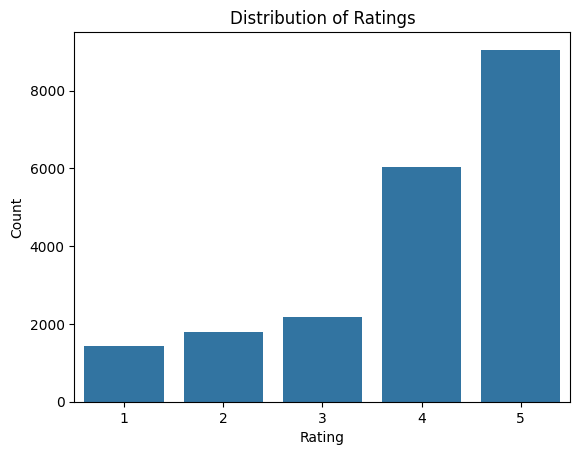

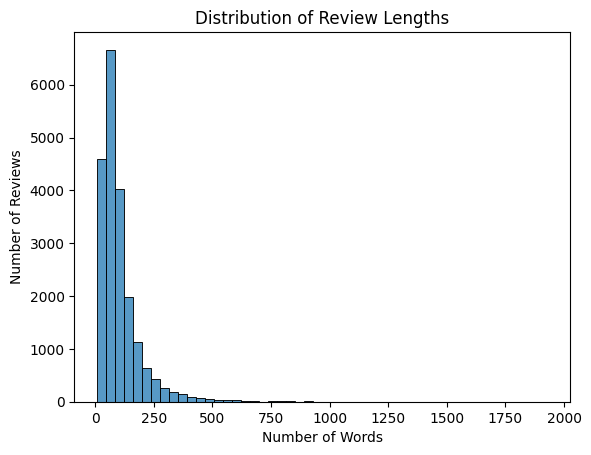

In [ ]:
sns.countplot(x='Rating', data=df)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

df['review_length'] = df['Review'].apply(lambda x: len(x.split()))
sns.histplot(df['review_length'], bins=50)
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.show()

# Part 2 - Text Preprocessing
Lowercasing, punctuation removal, stop word removal (excluding "not") and tokenization used in text preprocessing. Words were replaced by their stems and trigrams were extracted for analysis.

In [ ]:
stemmer = PorterStemmer()

def stem_tokenizer(text):
    tokens = re.findall(r"\b\w+\b", text.lower())
    return [stemmer.stem(token) for token in tokens]

custom_stopwords = list(set(ENGLISH_STOP_WORDS) - {'not'})

def load_and_preprocess_data(df, min_df=5, max_df=0.5):
    reviews = df['Review'].astype(str).values
    reviews = [re.sub(r'[^a-zA-Z\s]', '', review.lower()) for review in reviews]
    reviews = [re.sub(r'\bnt\b', 'not', review) for review in reviews]

    vectorizer = CountVectorizer(
        tokenizer=stem_tokenizer,
        ngram_range=(3, 3),
        max_df=max_df,
        min_df=min_df,
        stop_words=custom_stopwords
    )

    docs = torch.from_numpy(vectorizer.fit_transform(reviews).toarray()).float()

    assert docs.shape[0] == ratings_tensor.shape[0], "Mismatch between reviews and ratings"

    print(f"Dictionary size: {len(vectorizer.get_feature_names_out())}")
    print(f"Corpus size: {docs.shape}")
    return docs, vectorizer

# Part 3 - Probabilistic Model Building

Encoder and decoder if the model. Also, probabilistic LDA using pyro. Finally, train function with ELBO loss.


In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, num_topics, hidden, dropout):
        super().__init__()
        self.drop = nn.Dropout(dropout)
        self.fc1 = nn.Linear(vocab_size, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fcmu = nn.Linear(hidden, num_topics)
        self.fclv = nn.Linear(hidden, num_topics)

        self.bnmu = nn.BatchNorm1d(num_topics, affine=False)
        self.bnlv = nn.BatchNorm1d(num_topics, affine=False)



    def forward(self, inputs):
        h = F.softplus(self.fc1(inputs))
        h = F.softplus(self.fc2(h))
        h = self.drop(h)
        logtheta_loc = self.bnmu(self.fcmu(h))
        logtheta_logvar = self.bnlv(self.fclv(h))
        logtheta_scale = (0.5 * logtheta_logvar).exp()
        return logtheta_loc, logtheta_scale


class Decoder(nn.Module):
    def __init__(self, vocab_size, num_topics, dropout):
        super().__init__()
        self.beta = nn.Linear(num_topics, vocab_size, bias=False)
        self.bn = nn.BatchNorm1d(vocab_size, affine=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, inputs):
        inputs = self.drop(inputs)
        return F.softmax(self.bn(self.beta(inputs)), dim=1)


class ProdLDA(nn.Module):
    def __init__(self, vocab_size, num_topics, hidden, dropout):
        super().__init__()
        self.vocab_size = vocab_size
        self.num_topics = num_topics
        self.encoder = Encoder(vocab_size, num_topics, hidden, dropout)
        self.decoder = Decoder(vocab_size, num_topics, dropout)
        self.classifier = nn.Linear(vocab_size, 5)

    def model(self, docs, ratings=None):
        pyro.module("decoder", self.decoder)
        with pyro.plate("documents", docs.shape[0]):
            logtheta_loc = docs.new_zeros((docs.shape[0], self.num_topics))
            logtheta_scale = docs.new_ones((docs.shape[0], self.num_topics)) + 1e-6
            logtheta = pyro.sample("logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))
            theta = F.softmax(logtheta, -1)
            count_param = self.decoder(theta)
            total_count = int(docs.sum(-1).max())
            pyro.sample('obs', dist.Multinomial(total_count, count_param), obs=docs)

            if ratings is not None:
                phi = self.decoder.beta.weight.T
                doc_features = torch.matmul(theta, phi)
                logits = self.classifier(doc_features)
                pyro.sample("ratings", dist.Categorical(logits=logits), obs=ratings)

    def guide(self, docs, ratings=None):
        pyro.module("encoder", self.encoder)
        pyro.module("classifier", self.classifier)
        with pyro.plate("documents", docs.shape[0]):
            logtheta_loc, logtheta_scale = self.encoder(docs)
            logtheta = pyro.sample("logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))

    def beta(self):
        return self.decoder.beta.weight.cpu().detach().T

    def predict_ratings(self, docs):
        with torch.no_grad():
            logtheta_loc, _ = self.encoder(docs)
            theta = F.softmax(logtheta_loc, dim=1)
            phi = self.decoder.beta.weight.T
            doc_features = torch.matmul(theta, phi)
            logits = self.classifier(doc_features)
            predicted_classes = torch.argmax(logits, dim=1)
            return predicted_classes

def train_prodlda(docs, ratings=None, num_topics=10, batch_size=32, learning_rate=1e-3,
                  num_epochs=50, hidden=200, dropout=0.1):
    pyro.clear_param_store()
    prodLDA = ProdLDA(
        vocab_size=docs.shape[1],
        num_topics=num_topics,
        hidden=hidden,
        dropout=dropout
    )
    prodLDA.to(device)

    if ratings is not None:
        if isinstance(ratings, np.ndarray):
            ratings = torch.tensor(ratings, dtype=torch.float).to(device)
        elif isinstance(ratings, torch.Tensor):
            ratings = ratings.to(torch.long).to(device)

    optimizer = pyro.optim.Adam({"lr": learning_rate})
    svi = SVI(prodLDA.model, prodLDA.guide, optimizer, loss=TraceMeanField_ELBO())

    num_batches = int(math.ceil(docs.shape[0] / batch_size))
    elbo_losses = []
    bar = trange(num_epochs)

    for epoch in bar:
        running_loss = 0.0
        for i in range(num_batches):
            batch_docs = docs[i * batch_size:(i + 1) * batch_size, :]
            if ratings is not None:
                batch_ratings = ratings[i * batch_size:(i + 1) * batch_size]
                loss = svi.step(batch_docs, batch_ratings)
            else:
                loss = svi.step(batch_docs)
            running_loss += loss / batch_docs.size(0)
        elbo_losses.append(running_loss)
        bar.set_postfix(epoch_loss='{:.2e}'.format(running_loss))

    return prodLDA, elbo_losses

# Part 4 - Visualisation Functions

Function for plotting elbo for every training step. Topic word clouds. Visualizing topics, using main phrases that represent the topic. Function to calculate main metrics. Also, plotting between true and predicted parameters. Finally, function to calculate and plot correlation between topics and ratings.

In [ ]:
def plot_elbo_loss(elbo_losses):
    plt.figure(figsize=(7, 5))
    plt.plot(elbo_losses)
    plt.title("ELBO")
    plt.xlabel("Training Step")
    plt.ylabel("ELBO")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_word_cloud(beta, ax, vocab, topic_idx, num_words=100):
    sorted_, indices = torch.sort(beta, descending=True)
    feature_names = vocab
    word_dict = {i: word for i, word in enumerate(feature_names)}
    words = [word_dict[idx] for idx in indices[:num_words].numpy()]
    sizes = (sorted_[:num_words] * 1000).int().numpy().tolist()
    freqs = {words[i]: sizes[i] for i in range(len(words))}
    wc = WordCloud(background_color="white", width=800, height=500)
    wc = wc.generate_from_frequencies(freqs)
    ax.set_title(f'Topic {topic_idx + 1}')
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")


def visualize_topics(model, vectorizer, num_cols=3):
    beta = model.beta()
    num_topics = beta.shape[0]
    num_rows = (num_topics + num_cols - 1) // num_cols
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))
    feature_names = vectorizer.get_feature_names_out()
    for n in range(num_topics):
        i, j = divmod(n, num_cols)
        ax = axs[i, j] if num_rows > 1 else axs[j]
        plot_word_cloud(beta[n], ax, feature_names, n)
    for n in range(num_topics, num_rows * num_cols):
        i, j = divmod(n, num_cols)
        axs[i, j].axis('off') if num_rows > 1 else axs[j].axis('off')
    plt.tight_layout()
    plt.show()


def get_document_topics(model, docs, top_n=3):
    docs = docs.to(next(model.parameters()).device)
    with torch.no_grad():
        logtheta_loc, _ = model.encoder(docs)
        theta = F.softmax(logtheta_loc, dim=1)
    theta_np = theta.cpu().numpy()
    top_topics = []
    for doc_idx, doc_theta in enumerate(theta_np):
        top_indices = np.argsort(-doc_theta)[:top_n]
        top_probs = doc_theta[top_indices]
        for topic_idx, prob in zip(top_indices, top_probs):
            top_topics.append({
                'doc_idx': doc_idx,
                'topic': topic_idx + 1,
                'probability': prob
            })
    return pd.DataFrame(top_topics)


def evaluate_rating_prediction(model, docs, true_ratings):
    docs = docs.to(next(model.parameters()).device)
    predicted_ratings = model.predict_ratings(docs).cpu().numpy()
    if isinstance(true_ratings, torch.Tensor):
        true_ratings = true_ratings.cpu().numpy()
    mse = np.mean((predicted_ratings - true_ratings) ** 2)
    mae = np.mean(np.abs(predicted_ratings - true_ratings))
    ss_total = np.sum((true_ratings - np.mean(true_ratings)) ** 2)
    ss_residual = np.sum((true_ratings - predicted_ratings) ** 2)
    r_squared = 1 - (ss_residual / ss_total)
    correlation = np.corrcoef(true_ratings, predicted_ratings)[0, 1]
    return {
        'mse': mse,
        'mae': mae,
        'r_squared': r_squared,
        'correlation': correlation
    }


def plot_rating_prediction(model, docs, true_ratings, num_samples=100):
    docs = docs.to(next(model.parameters()).device)
    true_ratings = true_ratings.cpu().numpy()
    predicted_ratings = model.predict_ratings(docs).cpu().numpy()

    true_ratings += 1
    predicted_ratings += 1

    if len(true_ratings) > num_samples:
        indices = np.random.choice(len(true_ratings), num_samples, replace=False)
    else:
        indices = np.arange(len(true_ratings))

    true_sample = true_ratings[indices]
    pred_sample = predicted_ratings[indices]

    plt.figure(figsize=(10, 6))
    plt.scatter(true_sample, pred_sample, alpha=0.6)
    min_val = min(true_sample.min(), pred_sample.min())
    max_val = max(true_sample.max(), pred_sample.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.xlabel('True Ratings')
    plt.ylabel('Predicted Ratings')
    plt.title('True vs Predicted Ratings')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_topic_rating_correlation(model, docs, ratings, vectorizer):
    docs = docs.to(next(model.parameters()).device)
    with torch.no_grad():
        logtheta_loc, _ = model.encoder(docs)
        theta = F.softmax(logtheta_loc, dim=1).cpu().numpy()
    if isinstance(ratings, torch.Tensor):
        ratings = ratings.cpu().numpy()
    topic_correlations = []
    for i in range(theta.shape[1]):
        topic_proportion = theta[:, i]
        correlation = np.corrcoef(topic_proportion, ratings)[0, 1]
        topic_correlations.append({
            'topic': i + 1,
            'correlation': correlation
        })
    topic_correlations.sort(key=lambda x: abs(x['correlation']), reverse=True)
    topics = [t['topic'] for t in topic_correlations]
    corrs = [t['correlation'] for t in topic_correlations]
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(topics)), corrs)
    for i, corr in enumerate(corrs):
        bars[i].set_color('green' if corr > 0 else 'red')
    plt.xlabel('Topic')
    plt.ylabel('Correlation with Rating')
    plt.title('Topic Correlation with Ratings')
    plt.xticks(range(len(topics)), topics)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    beta = model.beta()
    feature_names = vectorizer.get_feature_names_out()
    for i in range(min(5, len(topics))):
        topic_idx = topics[i] - 1
        sorted_, indices = torch.sort(beta[topic_idx], descending=True)
        top_words = [feature_names[idx] for idx in indices[:5].numpy()]
        words_str = ', '.join(top_words)
        plt.annotate(f"Topic {topics[i]}: {words_str}",
                     xy=(i, corrs[i]),
                     xytext=(i, corrs[i] + (0.1 if corrs[i] > 0 else -0.1)),
                     ha='center', va='center',
                     bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))
    plt.tight_layout()
    plt.show()

# Part 5 - model training

Main code where data is loaded and training is done, using previously described functions.

In [ ]:
csv_file = "tripadvisor_hotel_reviews.csv"

num_topics = 15
batch_size = 32
learning_rate = 1e-2
num_epochs = 300

print("Loading and preprocessing data...")
df = pd.read_csv(csv_file)

df = df.dropna(subset=['Rating'])


df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

print("Total reviews before balancing:", len(df))
print("Counts per rating:\n", df['Rating'].value_counts())


ratings = df['Rating'].astype(int).values - 1
ratings_tensor = torch.tensor(ratings, dtype=torch.long)

docs, vectorizer = load_and_preprocess_data(df)
docs = docs.to(device)
ratings_tensor = ratings_tensor.to(device)

print("Training model with multiclass classification for ratings...")
model, elbo_losses = train_prodlda(docs, ratings_tensor, num_topics, batch_size, learning_rate, num_epochs)

Loading and preprocessing data...
Total reviews before balancing: 20491
Counts per rating:
 Rating
5    9054
4    6039
3    2184
2    1793
1    1421
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', '

Dictionary size: 15913
Corpus size: torch.Size([20491, 15913])
Training model with multiclass classification for ratings...


100%|██████████| 300/300 [38:19<00:00,  7.66s/it, epoch_loss=4.91e+04]


# Part 6 - Visualizing results

Metrics and results are visualized using previously described functions. Also, model is saved to .pt file, for future usage. Finally, creating a topic rating dataframe and saving it into csv file.

Visualizing discovered topics...


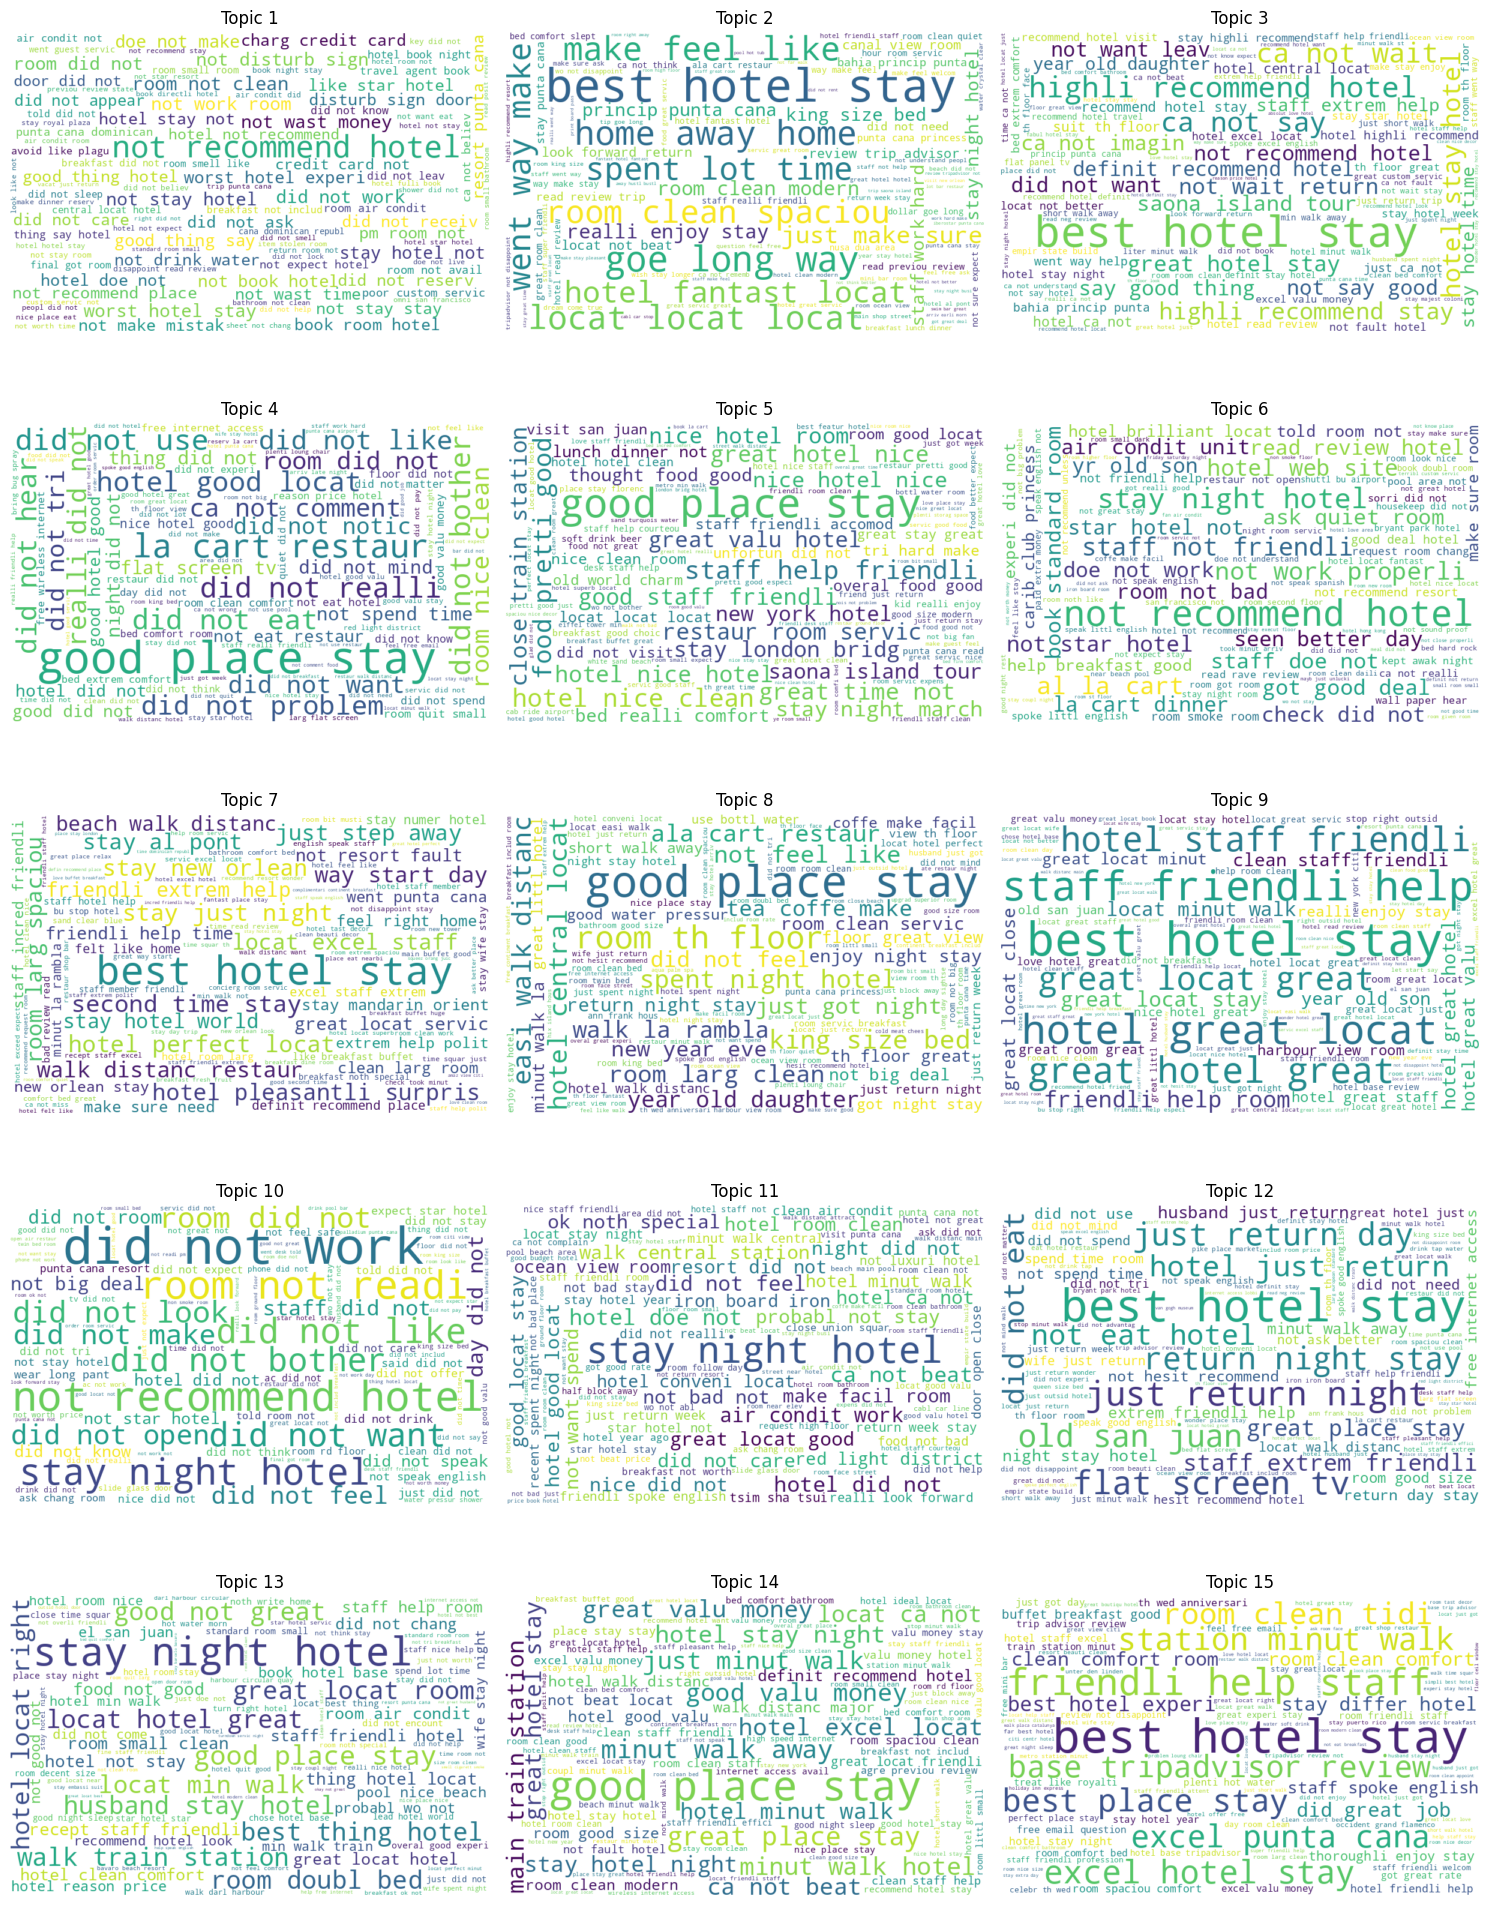

Evaluating rating prediction performance...
Rating prediction metrics:
  Mean Squared Error: 0.8174
  Mean Absolute Error: 0.4244
  R-squared: 0.4623
  Correlation: 0.7289
Plotting rating predictions...


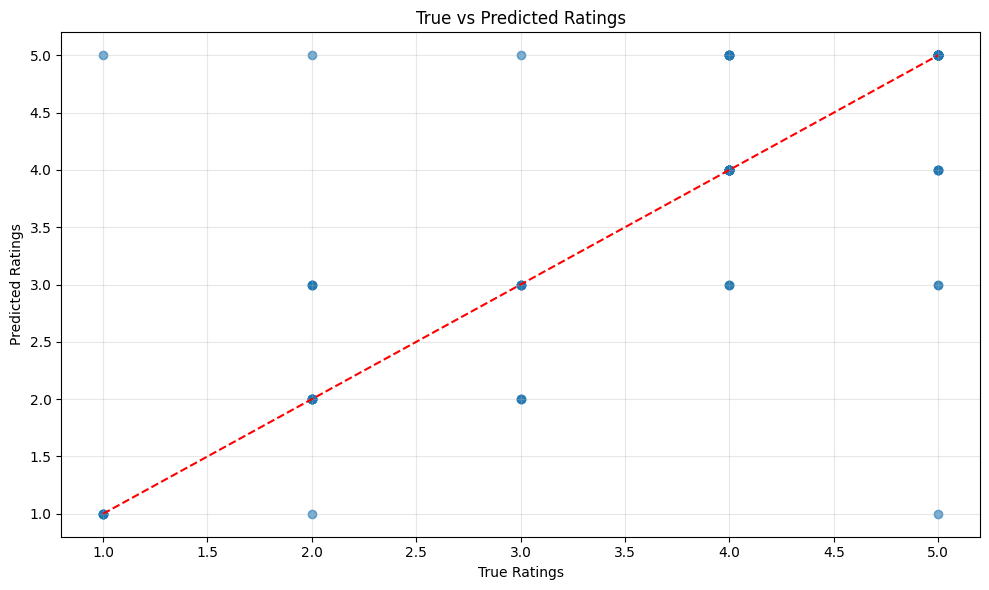

Analyzing topic-rating correlations...


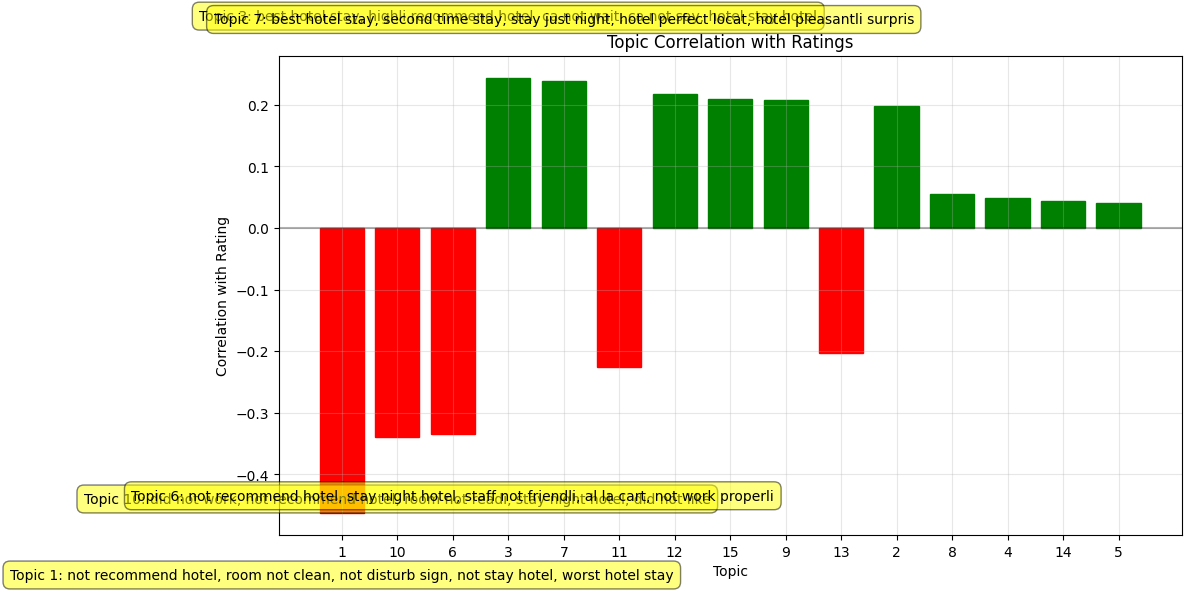

Top topics per document:
   doc_idx  topic  probability
0        0      8     0.578529
1        0      4     0.103580
2        0     15     0.054710
3        1     11     0.487954
4        1      1     0.067679
5        1     15     0.060900
6        2     10     0.408751
7        2      1     0.074381
8        2     13     0.067786
9        3      2     0.310507
Creating document topic-rating DataFrame...
Analysis complete!


In [ ]:
print("Visualizing discovered topics...")
visualize_topics(model, vectorizer)

print("Evaluating rating prediction performance...")
metrics = evaluate_rating_prediction(model, docs, ratings_tensor)
print(f"Rating prediction metrics:")
print(f"  Mean Squared Error: {metrics['mse']:.4f}")
print(f"  Mean Absolute Error: {metrics['mae']:.4f}")
print(f"  R-squared: {metrics['r_squared']:.4f}")
print(f"  Correlation: {metrics['correlation']:.4f}")

print("Plotting rating predictions...")
plot_rating_prediction(model, docs, ratings_tensor)

print("Analyzing topic-rating correlations...")
plot_topic_rating_correlation(model, docs, ratings_tensor, vectorizer)

top_doc_topics = get_document_topics(model, docs)
print("Top topics per document:")
print(top_doc_topics.head(10))

torch.save(model.state_dict(), "tripadvisor_prodlda_model.pt")

vocab_df = pd.DataFrame({
    'word': vectorizer.get_feature_names_out(),
    'index': range(len(vectorizer.get_feature_names_out()))
})
vocab_df.to_csv("tripadvisor_vocab.csv", index=False)

print("Creating document topic-rating DataFrame...")
doc_topics = np.zeros((docs.shape[0], num_topics))
with torch.no_grad():
    logtheta_loc, _ = model.encoder(docs)
    theta = F.softmax(logtheta_loc, dim=1).cpu().numpy()
    doc_topics = theta

topic_cols = [f'Topic_{i+1}' for i in range(num_topics)]
doc_topic_df = pd.DataFrame(doc_topics, columns=topic_cols)
doc_topic_df['Rating'] = ratings_tensor.cpu().numpy() + 1
doc_topic_df['Predicted_Rating'] = model.predict_ratings(docs).cpu().numpy() +1

doc_topic_df['Review'] = df['Review'].values

doc_topic_df.to_csv("tripadvisor_document_topics.csv", index=False)

print("Analysis complete!")

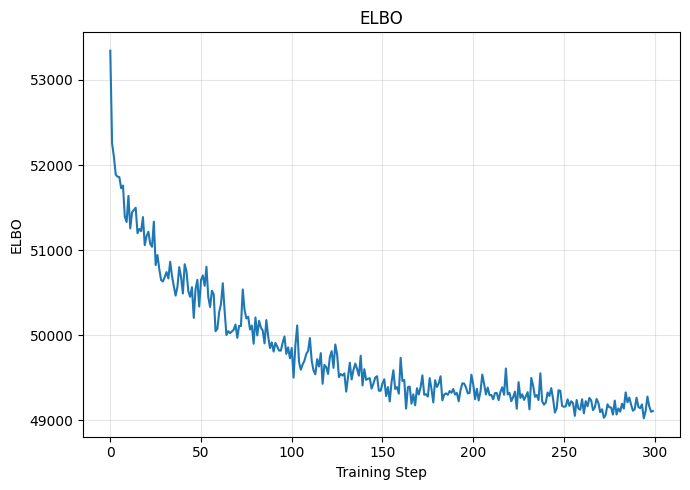

In [ ]:
plot_elbo_loss(elbo_losses)

Printing the top words per topic with their corresponding weights.

In [ ]:
def print_top_words_per_topic(model, vectorizer, num_words=10):
    beta = model.beta()
    feature_names = vectorizer.get_feature_names_out()

    for topic_idx, topic_weights in enumerate(beta):
        sorted_weights, top_indices = torch.sort(topic_weights, descending=True)
        top_words = [feature_names[i] for i in top_indices[:num_words].numpy()]
        top_vals = sorted_weights[:num_words].detach().numpy()

        print(f"\nTopic {topic_idx + 1}:")
        for word, weight in zip(top_words, top_vals):
            print(f"  {word:20} {weight:.4f}")

print_top_words_per_topic(model, vectorizer)


Topic 1:
  not recommend hotel  6.3333
  room not clean       1.3705
  not disturb sign     1.2634
  not stay hotel       1.2271
  worst hotel stay     1.2020
  did not work         1.1970
  room did not         1.1728
  not wast money       1.1487
  not work room        1.1451
  stay hotel not       1.0754

Topic 2:
  best hotel stay      4.0188
  goe long way         2.2000
  home away home       1.9909
  make feel like       1.9242
  locat locat locat    1.9007
  room clean spaciou   1.7529
  went way make        1.7370
  spent lot time       1.7153
  hotel fantast locat  1.7049
  just make sure       1.6858

Topic 3:
  best hotel stay      9.3399
  highli recommend hotel 3.4363
  ca not wait          3.0314
  ca not say           3.0279
  hotel stay hotel     2.5858
  highli recommend stay 2.1380
  not wait return      1.9500
  great hotel stay     1.9357
  saona island tour    1.8612
  not say good         1.8048

Topic 4:
  good place stay      6.5279
  la cart restaur      3.15

Additional analysis of the results. Printing confusion matric and accuracy for each rating.


Overall Accuracy: 69.65%


<ipython-input-43-be0969787649>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[1, 2, 3, 4, 5], y=per_class_acc, ax=axs[1], palette="viridis")


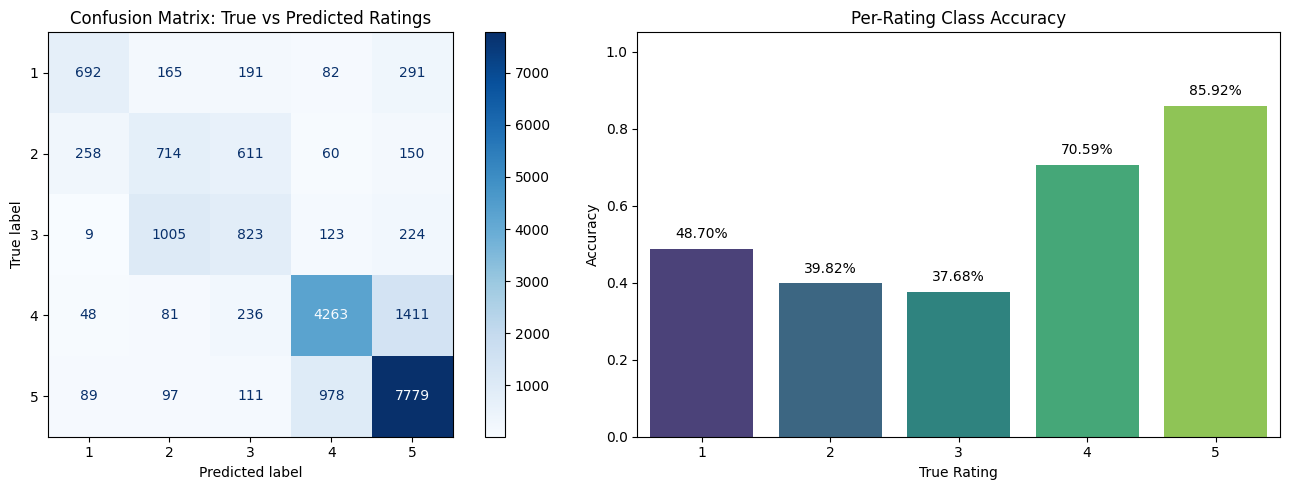

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

def plot_prediction_accuracy(model, docs, true_ratings):
    docs = docs.to(next(model.parameters()).device)
    true_ratings = true_ratings.cpu().numpy()
    predicted_ratings = model.predict_ratings(docs).cpu().numpy()

    true_ratings += 1
    predicted_ratings += 1

    cm = confusion_matrix(true_ratings, predicted_ratings, labels=[1, 2, 3, 4, 5])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5])

    print(f"\nOverall Accuracy: {accuracy_score(true_ratings, predicted_ratings):.2%}")

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    disp.plot(ax=axs[0], cmap="Blues", values_format='d')
    axs[0].set_title("Confusion Matrix: True vs Predicted Ratings")

    per_class_acc = (cm.diagonal() / cm.sum(axis=1))
    sns.barplot(x=[1, 2, 3, 4, 5], y=per_class_acc, ax=axs[1], palette="viridis")
    axs[1].set_ylim(0, 1.05)
    axs[1].set_title("Per-Rating Class Accuracy")
    axs[1].set_xlabel("True Rating")
    axs[1].set_ylabel("Accuracy")

    for i, acc in enumerate(per_class_acc):
        axs[1].text(i, acc + 0.02, f"{acc:.2%}", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

plot_prediction_accuracy(model, docs, ratings_tensor)